In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sys import getsizeof
from time import time

def mb_size_str(obj: object, name: str):
    return f"{name} size is {round(getsizeof(obj) / pow(1024, 2), 2)}MB"

import gensim
import logging

logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)

train_file = "train.csv"
train_df = pd.read_csv(train_file)
INPUT_DATASET_SIZE = train_df.shape[0]
b_time = time()

## Preprocessing

changeable configuration

In [12]:
cfg = {
    'TF_IDF': True,
    'LEMMATIZE': False,
    'DO_STEMMING': False,
    'STOPLIST': True,
    'LOWFREQ_FILTER': False,
    'LOWFREQ_TRESHOLD': 5,
    'TEST_RATIO': 0.2, # ratio of train samples that will go as test ones
    'MODEL': "6 Gensim Continuous Skipgram",
}

In [13]:
from tqdm import tqdm

# # # # # # # # # # # # # # # # # # # 
#           Preprocessing           #
# # # # # # # # # # # # # # # # # # # 

import src.preprocessing as prep

freq_dict = {}
token_amount_counter = [0]

print("Preprocessing...")
for row_id in tqdm(range(INPUT_DATASET_SIZE)):
    text = train_df.loc[row_id, "text"]
    train_df.loc[row_id, "text"] = prep.preprocess(
        text, cfg, freq_dict, token_amount_counter
    )

if cfg['LOWFREQ_FILTER']:
    forms_to_remove = set(w for (w, freq) in freq_dict.items() if freq <= cfg['LOWFREQ_TRESHOLD'])
    new_token_amount_counter = [0]
    print(f"Removing low freq tokens (freq <= {cfg['LOWFREQ_TRESHOLD']})...")
    print(f"Total forms: {len(freq_dict.items())}")
    print(f"Total forms to be removed {len(forms_to_remove)}")
    for row_id in tqdm(range(INPUT_DATASET_SIZE)):
        text = train_df.loc[row_id, "text"]
        train_df.loc[row_id, "text"] = prep.remove_lowfreq(text, forms_to_remove, new_token_amount_counter)
    shrink_percent = round(100 * (token_amount_counter[0] - new_token_amount_counter[0]) / token_amount_counter[0], 2)
    print(f"Total token amount:\nold {token_amount_counter[0]}\nnew {new_token_amount_counter[0]}\n{shrink_percent}% total less")

train_df.to_csv(f"train_cleaned.csv", index=False)

Preprocessing...


100%|██████████| 25000/25000 [00:13<00:00, 1857.14it/s]


### TF-IDF 

In [14]:
from src.tfidf import get_matrix
tfidf, matrix = get_matrix(train_df['text'].to_list()) if cfg['TF_IDF'] else (None, None)

INFO : TF-IDF matrix...
INFO : Матрица на 25000 документов и 144380 термов


### Word Vectors

In [15]:
# LOAD THE MODEL
from nltk.tokenize import word_tokenize
w2v_file = f"{cfg['MODEL']}/model.bin"
model: gensim.models.keyedvectors.KeyedVectors = gensim.models.KeyedVectors.load_word2vec_format(w2v_file, binary=True)
VECTOR_SIZE = model.vector_size

INFO : loading projection weights from 6 Gensim Continuous Skipgram/model.bin
INFO : KeyedVectors lifecycle event {'msg': 'loaded (302866, 300) matrix of type float32 from 6 Gensim Continuous Skipgram/model.bin', 'binary': True, 'encoding': 'utf8', 'datetime': '2023-02-14T22:46:58.793863', 'gensim': '4.2.0', 'python': '3.9.7 (default, Sep 16 2021, 08:50:36) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'load_word2vec_format'}


In [16]:
from src.vectorizers import get_tfidf_vector

def text_vector(text: str, text_id: int) -> np.ndarray:
    """Compute the normalized weighted mean w2v vector for a given text"""

    tokens = [token for token in word_tokenize(text) if token in model]
    # Compute the word2vec vectors for each word in the text
    vectors = [model.get_vector(tkn) for tkn in tokens]
    if cfg['TF_IDF']:
        # Compute the tf-idf values for each word in the text.
        tfidf_vals = get_tfidf_vector(tokens, text_id, matrix, tfidf)
        # Compute the weighted vectors by multiplying the word2vec vectors by the tf-idf values
        weighted_vecs = np.array([vec * factor for vec, factor in zip(vectors, tfidf_vals)])
    else:
        weighted_vecs = np.array(vectors)

    text_sum_vec = np.sum(weighted_vecs, axis=0)
    norm_vec = text_sum_vec / np.linalg.norm(text_sum_vec)
    
    return norm_vec

review_vectors = np.empty((INPUT_DATASET_SIZE, VECTOR_SIZE), dtype=float)
print(review_vectors.shape)
print("Calculating mean review vectors...")
for row_id in tqdm(range(INPUT_DATASET_SIZE)):
    review_vectors[row_id] = text_vector(train_df.loc[row_id, "text"], row_id)

(25000, 300)
Calculating mean review vectors...


100%|██████████| 25000/25000 [00:57<00:00, 431.13it/s]


In [17]:
# trying not to run out of memory on my potatoe (╥﹏╥)
print(getsizeof(review_vectors) / pow(1024, 2), "MB")
#model = None

57.22057342529297 MB


In [18]:
# concatenating tfidf and w2v vectors for each text
import src.vectorizers as vecs  
conc_matrix = vecs.concat_w2v(review_vectors, matrix)

100%|██████████| 25000/25000 [02:36<00:00, 159.27it/s]


# Training

In [19]:
answers = train_df['answer'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    conc_matrix,
    answers,
    test_size=cfg['TEST_RATIO']
)

print(f"""
    Total answers: {answers.shape[0]}
    Total reviews: {conc_matrix.shape[0]}
    Review vector size: {conc_matrix.shape[1]}
    Answers splitted: {y_train.shape[0]} / {y_test.shape[0]}
    Input splitted: {X_train.shape[0]} / {X_test.shape[0]}
    """)


    Total answers: 25000
    Total reviews: 25000
    Review vector size: 144680
    Answers splitted: 20000 / 5000
    Input splitted: 20000 / 5000
    


### logistic regression based on word2vec vectors

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from pprint import pprint

reg = LogisticRegression().fit(X_train, y_train)

diff = time() - b_time

results = {}
results.update(cfg)
print(f"""
    Score on
      - train  data : {reg.score(X_train, y_train)}
      - test   data : {reg.score(X_test, y_test)}
    Test/train size : {cfg['TEST_RATIO']}
    Total time      : {"{:.0f}m {:.0f}s".format(*divmod(diff, 60))}
""")



    Score on
      - train  data : 0.9266
      - test   data : 0.877
    Test/train size : 0.2
    Total time      : 4m 52s



/Users/caroline/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


```
      - train  data : 0.83735
      - test   data : 0.8364
    Test/train size : 0.2

    # + tfidf
      - train  data : 0.8083555555555556
      - test   data : 0.7952
    Test/train size : 0.1
```

#  Testing

In [21]:
def get_vector(text: str) -> np.ndarray:
    tokens = [token for token in word_tokenize(text) if token in model]
    # Compute the word2vec vectors for each word in the text
    vectors = np.array([model.get_vector(tkn) for tkn in tokens])
    sum_vector = np.sum(vectors, axis=0)
    norm_vector = sum_vector / np.linalg.norm(sum_vector)
    return norm_vector

test_file = "test.csv"
test_df = pd.read_csv(test_file)
TEST_DATASET_SIZE = test_df.shape[0]

# # # # # # # # # # # # # # # # # # # 
#             Processing            #
# # # # # # # # # # # # # # # # # # # 
print("Processing...")
result = test_df[["id"]].copy()
for row_id in tqdm(range(TEST_DATASET_SIZE)):
    text = test_df.loc[row_id, "text"]
    test_df.loc[row_id, "text"] = prep.preprocess(
        text, cfg, freq_dict, token_amount_counter
    )
    result.loc[row_id, "answer"] = int(reg.predict([get_vector(text)])[0])
test_df.to_csv(f"test_cleaned.csv", index=False)
result["answer"] = result["answer"].astype(int)
result.to_csv(f"result.csv", index=False)

Processing...


  0%|          | 0/25000 [00:00<?, ?it/s]


ValueError: X has 300 features per sample; expecting 144680

In [69]:
def get_vector(text: str) -> np.ndarray:
    tokens = [token for token in word_tokenize(text) if token in model]
    # Compute the word2vec vectors for each word in the text
    vectors = np.array([model.get_vector(tkn) for tkn in tokens])
    sum_vector = np.sum(vectors, axis=0)
    norm_vector = sum_vector / np.linalg.norm(sum_vector)
    return norm_vector

test_file = "test.csv"
test_df = pd.read_csv(test_file)
TEST_DATASET_SIZE = test_df.shape[0]

# # # # # # # # # # # # # # # # # # # 
#             Processing            #
# # # # # # # # # # # # # # # # # # # 
print("Processing...")
result = test_df[["id"]].copy()
for row_id in tqdm(range(TEST_DATASET_SIZE)):
    text = test_df.loc[row_id, "text"]
    test_df.loc[row_id, "text"] = prep.preprocess(
        text, cfg, freq_dict, token_amount_counter
    )
    result.loc[row_id, "answer"] = int(reg.predict([get_vector(text)])[0])
test_df.to_csv(f"test_cleaned.csv", index=False)
result["answer"] = result["answer"].astype(int)
result.to_csv(f"result.csv", index=False)

Processing...


  0%|          | 0/25000 [00:00<?, ?it/s]


ValueError: X has 300 features per sample; expecting 144680

#### metrics

In [10]:
from sklearn.metrics import accuracy_score, f1_score


In [11]:
y_pred = reg.predict(X_test)

In [12]:
accuracy_score(y_test, y_pred)

0.7594

In [13]:
f1_score(y_test, y_pred)

0.7595442734359384

# trying bag of words method

##### configuring bag of words

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_df=0.90, max_features=2000, stop_words='english')

bow = bow_vectorizer.fit_transform(train_df['text'])

df_bow = pd.DataFrame(bow.todense())

df_bow

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
from sklearn.model_selection import train_test_split

In [25]:
train_bow = bow.todense()

splitting the data

In [26]:
x_train_bow, x_valid_bow, y_train_bow, y_valid_bow = train_test_split(train_bow,train_df['answer'],test_size=0.3,random_state=2)

## Logistic Regression

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score

In [28]:
bagreg = LogisticRegression(random_state=0,solver='saga', max_iter=10000)

fitting

In [29]:
bagreg.fit(x_train_bow, y_train_bow)

LogisticRegression(max_iter=10000, random_state=0, solver='saga')

In [30]:
prediction_bow = bagreg.predict_proba(x_valid_bow)

In [31]:
prediction_int = prediction_bow[:,1]>=0.3

prediction_int = prediction_int.astype(int)

log_bow = f1_score(y_valid_bow, prediction_int)

log_bow

0.8510743393430478

### no change of parameters helped :(

### XGboost

In [32]:
from xgboost import XGBClassifier

In [33]:
model_bow = XGBClassifier(random_state=0,learning_rate=0.9)


In [34]:
model_bow.fit(x_train_bow, y_train_bow)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.9, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

In [50]:
xgb = model_bow.predict_proba(x_valid_bow)

In [51]:
xgb=xgb[:,1]>=0.3

xgb_int=xgb.astype(int)

xgb_bow = f1_score(y_valid_bow,xgb_int)

In [52]:
accuracy_score(y_valid_bow, xgb_int)

0.8284

## Decision Tree

In [38]:
from sklearn.tree import DecisionTreeClassifier
dct = DecisionTreeClassifier(criterion='entropy', splitter='random', random_state=1)

In [39]:
dct.fit(x_train_bow,y_train_bow)

DecisionTreeClassifier(criterion='entropy', random_state=1, splitter='random')

In [58]:
dct_bow = dct.predict_proba(x_valid_bow)

In [59]:
dct_bow=dct_bow[:,1]>=0.3

dct_int_bow=dct_bow.astype(int)

dct_score_bow=f1_score(y_valid_bow,dct_int_bow)

dct_score_bow

0.714855168748339

this is just very bad and I can't help it

In [60]:
algs = ['logistic regression','XGB','Decision Tree']

score_1 = [log_bow,xgb_bow,dct_score_bow]

compare_1 = pd.DataFrame({'Model':algs,'F1_Score':score_1},index=[i for i in range(1,4)])


In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

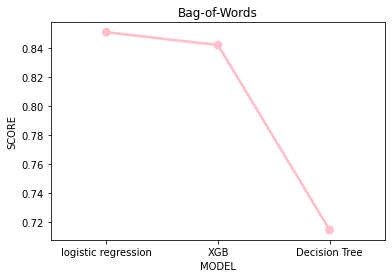

In [68]:
sns.pointplot(x='Model',y='F1_Score',data=compare_1, color='pink')

plt.title('Bag-of-Words')
plt.xlabel('MODEL')
plt.ylabel('SCORE')

plt.show()

obviously the one with logistic regression is the best one